# Linear Model MCMC
Part of the Bayesian neural networks via MCMC: a Python-based tutorial

This section of the tutorial covers the development of an MCMC algorithm applied to a simple linear model.

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, widgets
# visulisation function
from functions.visualisations import (
    histogram_trace, plot_linear_data,
    plot_y_timeseries, boxplot_weights,
    plot_ycorr_scatter
)

from types import MethodType

np.random.seed(2023)

## Define a class with the functions and attributes required for a linear model

- `predict`: Function to output y given the input data and model parameters - $y = w x + b$
- `evaluate_proposal`: Function to load a given proposal distribution ($\theta$) and return the model prediction
- `encode`: Helper function to encode the model parameters ($\theta$) into the model as $w$ and $b$

In [2]:
class LinearModel:
    '''
    Simple linear model with a single output (y) given the covariates x_1...x_M of the form:
    y = w_1 * x_1 + ... + w_M * x_M + b
    where M = number of features, w are the weights, and b is the bias.
    '''
    # Initialise values of model parameters
    def __init__(self):
        self.w = None
        self.b = None 

    # Function to take in data and parameter sample and return the prediction
    def evaluate_proposal(self, data, theta):
        '''
        Encode the proposed parameters and then use the model to predict
        Input:
            data: (N x M) array of data
            theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
        '''
        self.encode(theta)  # method to encode w and b
        prediction = self.predict(data) # predict and return
        return prediction

    # Linear model prediction
    def predict(self, x_in):
        y_out = x_in.dot(self.w) + self.b 
        return y_out
    
    # Helper function to split the parameter vector into w and band store in the model
    def encode(self, theta):
        self.w =  theta[0:-1]
        self.b = theta[-1] 

## Define a class for the MCMC sampling

$y=f\left(x,\theta\right)+e \qquad e \sim N\left(0,\tau^2\right)$

First we will define the likelihood and prior functions

In [3]:
# Define the likelihood function
def likelihood_function(self, theta, tausq, test=False):
    '''
    Calculate the likelihood of the data given the parameters
    Input:
        theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
        tausq: variance of the error term
    Output:
        log_likelihood: log likelihood of the data given the parameters
        model_prediction: prediction of the model given the parameters
        accuracy: accuracy (RMSE) of the model given the parameters
    '''
    # first make a prediction with parameters theta
    if test:
        x_data = self.x_test
        y_data = self.y_test
    else:
        x_data = self.x_data
        y_data = self.y_data
    # first make a prediction with parameters theta
    model_prediction = self.model.evaluate_proposal(x_data, theta)
    model_simulation = model_prediction + np.random.normal(0,tausq,size=model_prediction.shape) 
    accuracy = self.rmse(model_prediction, y_data) #RMSE error metric 
    # now calculate the log likelihood
    log_likelihood = np.sum(-0.5 * np.log(2 * np.pi * tausq) - 0.5 * np.square(y_data - model_prediction) / tausq)
    return [log_likelihood, model_prediction, model_simulation, accuracy] 

# Define the prior
def prior(self, sigma_squared, nu_1, nu_2, theta, tausq): 
    '''
    Calculate the prior of the parameters
    Input:
        sigma_squared: variance of normal prior for theta
        nu_1: parameter nu_1 of the inverse gamma prior for tau^2
        nu_2: parameter nu_2 of the inverse gamma prior for tau^2
        theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
        tausq: variance of the error term
    Output:
        log_prior: log prior
    '''
    n_params = self.theta_size # number of parameters in model
    part1 = -1 * (n_params / 2) * np.log(sigma_squared)
    part2 = 1 / (2 * sigma_squared) * (sum(np.square(theta)))
    log_prior = part1 - part2 - (1 + nu_1) * np.log(tausq) - (nu_2 / tausq)
    return log_prior

Next define the MCMC sampler

In [4]:
# MCMC sampler
def sampler(self):
    '''
    Run the sampler for a defined linear model
    '''
    ## Define empty arrays to store the sampled posterior values
    # posterior of all weights and bias over all samples
    pos_theta = np.ones((self.n_samples, self.theta_size)) 
    # posterior defining the variance of the noise in predictions
    pos_tau = np.ones((self.n_samples, 1))
    pos_eta = np.ones((self.n_samples, 1))

    # record output f(x) over all samples
    pred_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record simulated values f(x) + error over all samples 
    sim_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record the RMSE of each sample
    rmse_data = np.zeros(self.n_samples)
    # now for test
    test_pred_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_sim_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_rmse_data = np.zeros(self.n_samples)

    ## Initialisation
    # initialise theta - the model parameters
    theta = np.random.randn(self.theta_size)
    # make initial prediction
    pred_y[0,] = self.model.evaluate_proposal(self.x_data, theta)

    # initialise eta - we sample eta as a gaussian random walk in the log space of tau^2
    eta = np.log(np.var(pred_y[0,] - self.y_data))
    tausq_proposal = np.exp(eta)

    # calculate the prior
    prior_val = self.prior(self.sigma_squared, self.nu_1, self.nu_2, theta, tausq_proposal)
    # calculate the log-likelihood considering observations
    [likelihood, pred_y[0,], sim_y[0,], rmse_data[0]] = self.likelihood_function(theta, tausq_proposal)

    n_accept = 0  
    ## Run the MCMC sample for n_samples
    for ii in np.arange(1,self.n_samples):
        # Sample new values for theta and tau using a Gaussian random walk
        theta_proposal = theta + np.random.normal(0, self.step_theta, self.theta_size)
        eta_proposal = eta + np.random.normal(0, self.step_eta, 1) # sample tau^2 in log space
        tausq_proposal = np.exp(eta_proposal)   

        # calculate the prior
        prior_proposal = self.prior(
            self.sigma_squared, self.nu_1, self.nu_2, theta_proposal, tausq_proposal
        )
        # calculate the log-likelihood considering observations
        [likelihood_proposal, pred_y[ii,], sim_y[ii,], rmse_data[ii]] = self.likelihood_function(
            theta_proposal, tausq_proposal
        )

         # calculate the test likelihood
        [_, test_pred_y[ii,], test_sim_y[ii,], test_rmse_data[ii]] = self.likelihood_function(
            theta_proposal, tausq_proposal, test=True
        )

        # Noting that likelihood_function and prior_val return log likelihoods,
        # we can use log laws to calculate the acceptance probability
        diff_likelihood = likelihood_proposal - likelihood
        diff_prior = prior_proposal - prior_val

        mh_prob = min(1, np.exp(diff_likelihood + diff_prior))

        # sample to accept or reject the proposal according to the acceptance probability
        u = np.random.uniform(0, 1)
        if u < mh_prob:
            # accept and update the values
            n_accept += 1
            likelihood = likelihood_proposal
            prior_val = prior_proposal
            theta = theta_proposal
            eta = eta_proposal
            # store to make up the posterior
            pos_theta[ii,] = theta_proposal
            pos_tau[ii,] = tausq_proposal
            pos_eta[ii,] = eta_proposal
        else:
            # reject move and store the old values
            pos_theta[ii,] = pos_theta[ii-1,]
            pos_tau[ii,] = pos_tau[ii-1,]
            pos_eta[ii,] = pos_eta[ii-1,]

    # calculate the acceptance rate as a check
    accept_rate = (n_accept / self.n_samples) * 100
    print('{:.3f}% were accepted'.format(accept_rate))

    # store the posterior (samples after burn in) in a pandas dataframe and return
    self.pos_theta = pos_theta[self.n_burnin:, ]
    self.pos_tau = pos_tau[self.n_burnin:, ] 
    self.pos_eta = pos_eta[self.n_burnin:, ]
    self.rmse_data = rmse_data[self.n_burnin:]

    # split theta into w and b
    results_dict = {'w{}'.format(_): self.pos_theta[:, _].squeeze() for _ in range(self.theta_size-1)}
    results_dict['b'] = self.pos_theta[:, -1].squeeze()
    results_dict['tau'] = self.pos_tau.squeeze()
    results_dict['rmse'] = self.rmse_data.squeeze()

    # return the predictions
    pred_dict = {}
    pred_dict['train_pred'] = pred_y[self.n_burnin:,:]
    pred_dict['train_sim'] = sim_y[self.n_burnin:,:]
    pred_dict['test_pred'] = test_pred_y[self.n_burnin:,:]
    pred_dict['test_sim'] = test_sim_y[self.n_burnin:,:]

    results_df = pd.DataFrame.from_dict(
        results_dict
    )
    return results_df, pred_dict

Define a function to generate random draws from the posterior distributions

Finally combine these elements into a MCMC sampling function

In [5]:
class MCMC:
    def __init__(self, n_samples, n_burnin, x_data, y_data, x_test, y_test):
        self.n_samples = n_samples # number of MCMC samples
        self.n_burnin = n_burnin # number of burn-in samples
        self.x_data = x_data # (N x M)
        self.y_data = y_data # (N x 1)
        self.x_test = x_test # (Nt x num_features)
        self.y_test = y_test # (Nt x 1)

        # MCMC sampler hyperparameters - defines the variance term in our Gaussian random walk
        self.step_theta = 0.02;  
        self.step_eta = 0.01; # note eta is used as tau in the sampler to consider log scale.  
        
        # model hyperparameters
        # considered by looking at distribution of  similar trained  models - i.e distribution of weights and bias
        self.sigma_squared = 5
        self.nu_1 = 1
        self.nu_2 = 0.5

        # initisalise the linear model class
        self.model = LinearModel()
        self.theta_size = x_data.shape[1] + 1 # weights for each feature and a bias term (M+1)

        # store output
        self.pos_theta = None
        self.pos_tau = None
        self.pos_eta = None
        self.rmse_data = None

        # functions defined above - this is poor practice, but done for readability 
        # and clarity
        self.likelihood_function = MethodType(likelihood_function, self)
        self.prior = MethodType(prior, self)
        self.sampler = MethodType(sampler, self)

    # Additional error metric
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

## Load the data
- Load in the suspot data
- You can also load in the other regeression datasets `Lazer` and `Energy`

In [6]:
# load the data
name        = "Sunspot"
train_data   = np.loadtxt("data/{}/train.txt".format(name))
test_data    = np.loadtxt("data/{}/test.txt".format(name))

print('Training data shape: {}'.format(train_data.shape))

Training data shape: (298, 5)


## Sample using MCMC

- Create the MCMC loop and sample the posterior distribution

In [7]:
## MCMC Settings and Setup
n_samples = 25000 # number of samples to draw from the posterior
burn_in = int(n_samples* 0.25) # number of samples to discard before recording draws from the posterior
data_case = 'Sunspot' # 'sunspot'

# or load from sunspot data
x_data = train_data[:,:-1]
y_data = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]

# Initialise the MCMC class
mcmc = MCMC(n_samples, burn_in, x_data, y_data, x_test, y_test)
# Run the sampler
results, pred = mcmc.sampler()

11.192% were accepted


In [8]:
# gather the predicitons into useful variables
pred_y = pred['train_pred']
sim_y = pred['train_sim']
pred_y_test = pred['test_pred']
sim_y_test = pred['test_sim']

## Analyse the results
Plot the data with the mean linear fit and some uncertainty.

Plot the posterior distribution and trace for each parameter using ipywidgets.

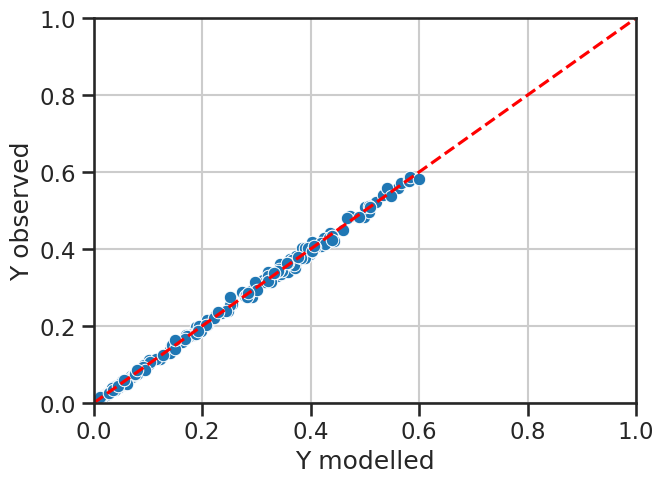

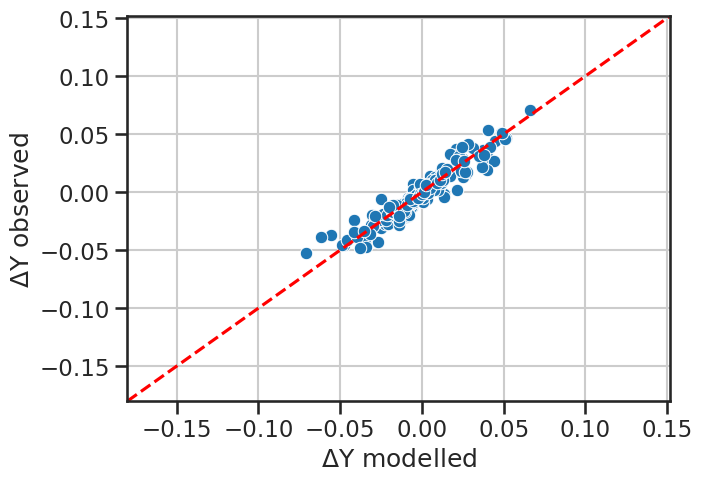

In [9]:
# plot the data with the model predictions from posterior draws
plot_ycorr_scatter(
    y_test,
    pred_y_test
)
plot_ycorr_scatter(
    np.diff(y_test),
    pred_y_test[:,1:] - y_test[:-1],
    minmax=None,
    dy=True
)

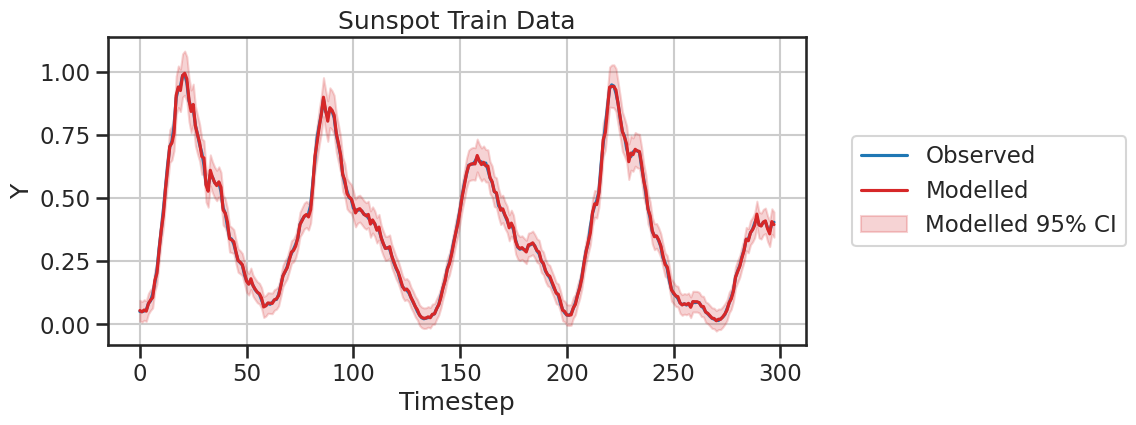

In [10]:
plot_y_timeseries(
    y_data,
    pred_y,
    dataset_name=name + ' Train',
    ci=True
)

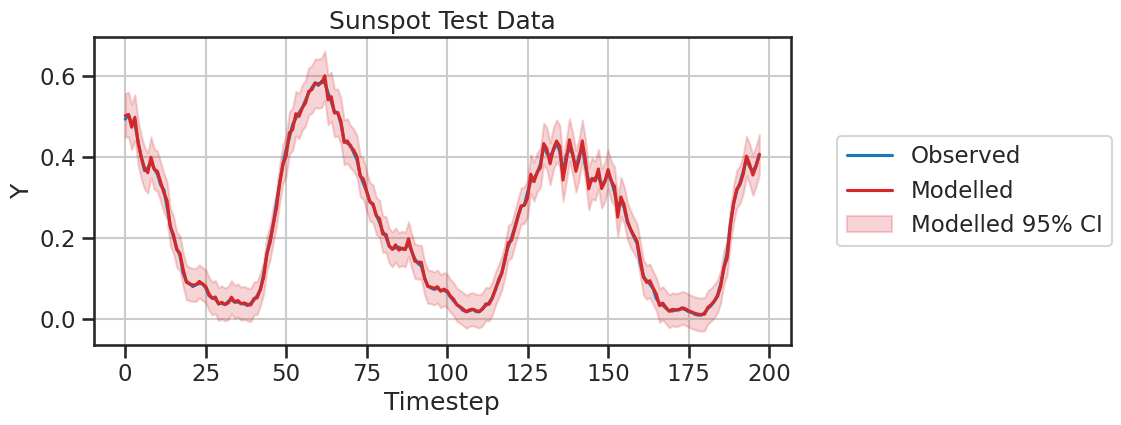

In [11]:
plot_y_timeseries(
    y_test,
    pred_y_test,
    dataset_name=name + ' Test',
    ci=True
)

In [12]:
# Print the train/test RMSE
trainRMSE = np.array([mcmc.rmse(pred_y[_,:], y_data) for _ in np.arange(pred_y.shape[0])])
testRMSE = np.array([mcmc.rmse(pred_y_test[_,:], y_test) for _ in np.arange(pred_y_test.shape[0])])

print('Train RMSE: {:.5f} ({:.5f})'.format(trainRMSE.mean(),trainRMSE.std()))
print('Test RMSE: {:.5f} ({:.5f})'.format(testRMSE.mean(),testRMSE.std()))

Train RMSE: 0.02524 (0.01343)
Test RMSE: 0.02174 (0.01175)


In [13]:
def plot_hist(results, param_name):
    # results = results_rmse
    posterior_mean = results[param_name].mean()
    print('{:.3f} mean value of posterior'.format(posterior_mean))
    histogram_trace(results[param_name].values)

# use ipywidgets to get a "gui" dropdown to view all the parameters
interact(
    plot_hist, 
    results=fixed(results), 
    param_name=widgets.Dropdown(
        options=results.columns,
        value='w0',
        description='Parameter:',
    )
)
None

interactive(children=(Dropdown(description='Parameter:', options=('w0', 'w1', 'w2', 'w3', 'b', 'tau', 'rmse'),…

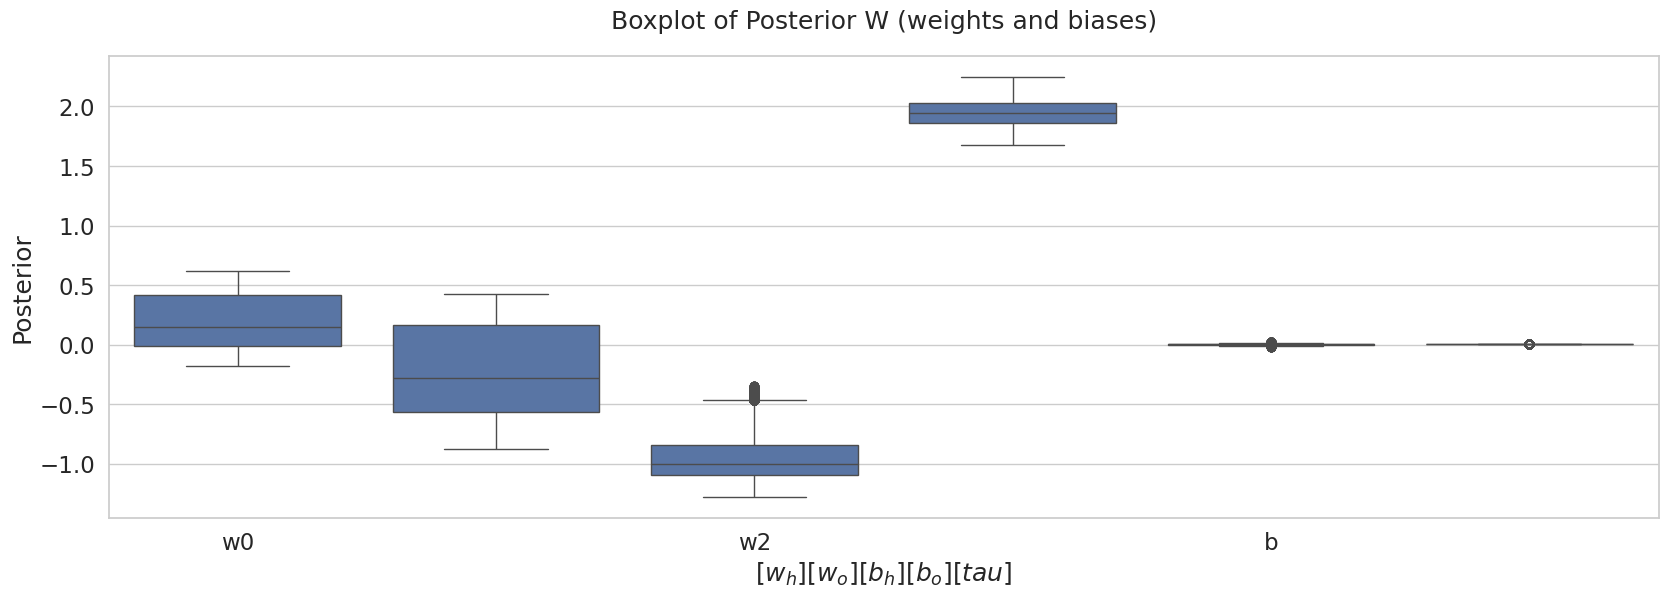

In [14]:
# Visualise all the network weights
boxplot_weights(results,width=20)

# Demonstration of convergence diagnostics
Here we will use the package ArviZ to assess the convergence of the MCMC sampler. To calculate the Rhat convergence diagnostic, we need at least 2 chains. An Rhat value close to 1 indicates convergence.

In [16]:
import arviz as az
# Sample a second chain as more than one chain is required to generate the Rhat diagnostic
# Run second chain using a different seed
np.random.seed(2)
# setup second chain
mcmc_chain2 = MCMC(n_samples, burn_in, x_data, y_data, x_test, y_test)
# Run the sampler
results_chain2, _ = mcmc_chain2.sampler()

# Now combine these two chains by stacking and convert to arviz dataset
# To convert to arviz, convert the pandas dataframe of samples into a dictionary of lists, stack and ingest into arviz
res_dict = results.to_dict(orient='list')
res_dict_chain2 = results_chain2.to_dict(orient='list')
# stack the chains looping through each parameter
az_results = az.from_dict({par: np.vstack([res_dict[par], res_dict_chain2[par]]) for par in res_dict})

# now we can use arviz to obtain summary statistics with Rhat ("r_hat") for each parameter.
az.summary(az_results)

12.460% were accepted


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,-0.212,0.455,-0.902,0.561,0.306,0.254,3.0,11.0,2.30
w1,0.649,0.926,-0.786,1.864,0.644,0.542,2.0,12.0,2.46
w2,-1.523,0.627,-2.363,-0.466,0.431,0.363,3.0,12.0,2.26
w3,2.082,0.199,1.787,2.473,0.113,0.090,3.0,26.0,1.62
b,0.002,0.006,-0.009,0.014,0.000,0.000,1347.0,1737.0,1.01
tau,0.003,0.000,0.003,0.004,0.000,0.000,15.0,22.0,1.16
rmse,0.025,0.014,0.007,0.051,0.000,0.000,28369.0,1922.0,1.00
